1. Understanding The Data

1.1. Importing Required Libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

1.2. Mouting Google Drive Input Data in Colab Notebook

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


1.3 Understanding Data

In [4]:
train_data_path="gdrive/MyDrive/SkinCancerData/Train/"
disease_types_train=os.listdir(train_data_path)

test_data_path="gdrive/MyDrive/SkinCancerData/Test/"
disease_types_test=os.listdir(test_data_path)

print("Disease Types in Train Data: {}".format(disease_types_train))
print("Disease Types in Test Data: {}".format(disease_types_test))

Disease Types in Train Data: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Disease Types in Test Data: ['actinic keratosis', 'dermatofibroma', 'basal cell carcinoma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [5]:
# Let us now look at distribution of images among various disease types

for i in disease_types_train:
    tr_d_path = train_data_path + i
    te_d_path = test_data_path + i
    len_tr_d = len(os.listdir(tr_d_path))
    len_te_d = len(os.listdir(te_d_path))
    te_tr_r = len_te_d/len_tr_d*100
    print("Disease Name: {: <26} | Train Images: {: <3} | Test Images: {: <2}".
          format(i, len_tr_d, len_te_d, te_tr_r))

Disease Name: actinic keratosis          | Train Images: 114 | Test Images: 16
Disease Name: basal cell carcinoma       | Train Images: 376 | Test Images: 16
Disease Name: dermatofibroma             | Train Images: 95  | Test Images: 16
Disease Name: melanoma                   | Train Images: 400 | Test Images: 16
Disease Name: nevus                      | Train Images: 270 | Test Images: 16
Disease Name: pigmented benign keratosis | Train Images: 432 | Test Images: 16
Disease Name: seborrheic keratosis       | Train Images: 77  | Test Images: 3 
Disease Name: squamous cell carcinoma    | Train Images: 181 | Test Images: 16
Disease Name: vascular lesion            | Train Images: 139 | Test Images: 3 


In [6]:
# Let us now count total train and test images in the given dataset

data_dir_train = pathlib.Path(train_data_path)
data_dir_test = pathlib.Path(test_data_path)
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("There are total {} images in the Train Dataset".format(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("There are total {} images in the Train Dataset".format(image_count_test))


There are total 2084 images in the Train Dataset
There are total 118 images in the Train Dataset


2. Data Preparation and Preprocessing

In [7]:
# Dataset Creation using given parameters

batch_size = 32
image_height = 180
image_width = 180

2.1 Creating Data Sets for training the models

We will be using only training images for our model building.

Out of these we will distribute them to train and validation data in 80:20 ratio.

In [8]:
# using keras to get 80% of the train images as train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2084 files belonging to 9 classes.
Using 1668 files for training.


In [9]:
# using keras to get 20% of the train images as validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2084 files belonging to 9 classes.
Using 416 files for validation.


In [10]:
# we get list of categories (types of diseases) as class_names from train and validation datasets
# we can consider any of these dataset to get list of class_names (categories that we want to classfiy during model training exercise)
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
train_ds.batch

<bound method DatasetV2.batch of <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>>

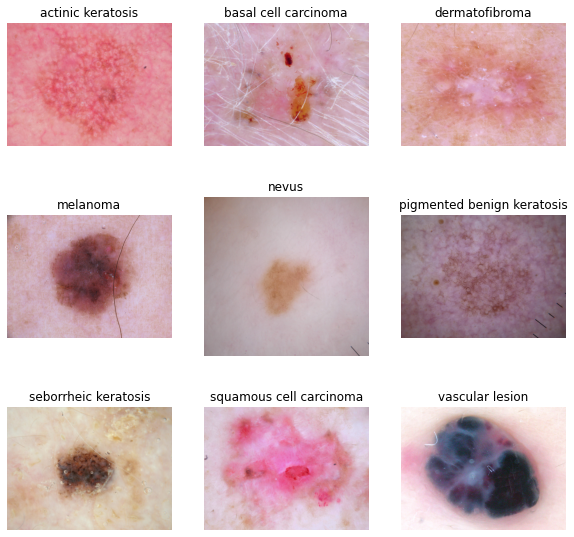

In [12]:
# let us have a look at an image from every category of skin cancer
# we will be using PIL to draw image on the plots (provided by matplotlib)
num=0
plt.figure(figsize=(10, 10))
for i in train_ds.class_names:
  for j in os.listdir(train_data_path + i):
    #print("Disease: {} | ImageName: {}".format(i, j))
    img = PIL.Image.open(str(train_data_path + i)+"/"+str(j))
    #print("Disease: {} | ImageName: {}".format(i, j, img.category))
    plt.subplot(3,3,num+1)
    plt.title(i)
    plt.axis('off')
    plt.imshow(img)
    num=num+1
    break

We can see that, the above images are color images. Hence they are 3 dimensional. Since we have defined image height and width at 180, the shape of this image will be 180x180x3 where 3 indicates RGB (Red-Green-Blue) color.

Each batch consists of 32 such images so the shae of this tensor will be (32 x 180 x 180 x 3)


Also as a part of preprocessing, 

a. We will use cache option of dataset which will load the data from disk to memory first and later will access this data from memory instead of disk everytime it will try to use it. This will help in improving performance in terms of access time.

b. Shuffle option we will use so that model does not learn anything from the order of the data that is present in the dataset

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

3. Model Building

3.1 First Model - A Very Basic Model

In [14]:
# for better model building exercise, I will be using this clear_session option almost before every model building/training activity
# this will be effective use of tensor graph which can also boost overall performance of this exercise

tf.keras.backend.clear_session()
model_basic=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

### Choosing "ADAM" optimizer
### Since we are solving a multiclass problem we will use 'categorical_crossntropy' loss function
### Metric used for decision making is 'accuracy'
model_basic.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20
history = model_basic.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
53/53 [==============================] - 249s 904ms/step - loss: 4.0012 - accuracy: 0.1871 - val_loss: 1.9166 - val_accuracy: 0.3053
Epoch 2/20
53/53 [==============================] - 2s 39ms/step - loss: 1.8937 - accuracy: 0.3082 - val_loss: 1.7617 - val_accuracy: 0.4255
Epoch 3/20
53/53 [==============================] - 2s 38ms/step - loss: 1.7387 - accuracy: 0.3837 - val_loss: 1.7514 - val_accuracy: 0.4519
Epoch 4/20
53/53 [==============================] - 2s 38ms/step - loss: 1.7303 - accuracy: 0.3855 - val_loss: 1.7626 - val_accuracy: 0.4207
Epoch 5/20
53/53 [==============================] - 2s 38ms/step - loss: 1.6069 - accuracy: 0.4382 - val_loss: 1.5141 - val_accuracy: 0.4447
Epoch 6/20
53/53 [==============================] - 2s 38ms/step - loss: 1.5473 - accuracy: 0.4628 - val_loss: 1.5434 - val_accuracy: 0.4688
Epoch 7/20
53/53 [==============================] - 2s 38ms/step - loss: 1.4474 - accuracy: 0.5096 - val_loss: 1.4767 - val_accuracy: 0.5096
Epoch 8/20

In [17]:
model_basic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

3.1.1 Second Basic Model

In [15]:
model_basic2=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

model_basic2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20
history1 = model_basic2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
53/53 [==============================] - 4s 60ms/step - loss: 2.1454 - accuracy: 0.2062 - val_loss: 2.0424 - val_accuracy: 0.2380
Epoch 2/20
53/53 [==============================] - 3s 54ms/step - loss: 1.9554 - accuracy: 0.2542 - val_loss: 1.8354 - val_accuracy: 0.3125
Epoch 3/20
53/53 [==============================] - 3s 54ms/step - loss: 1.7560 - accuracy: 0.3561 - val_loss: 1.7344 - val_accuracy: 0.3678
Epoch 4/20
53/53 [==============================] - 3s 55ms/step - loss: 1.6672 - accuracy: 0.3969 - val_loss: 1.5385 - val_accuracy: 0.4784
Epoch 5/20
53/53 [==============================] - 3s 55ms/step - loss: 1.4812 - accuracy: 0.4772 - val_loss: 1.5773 - val_accuracy: 0.4351
Epoch 6/20
53/53 [==============================] - 3s 54ms/step - loss: 1.4227 - accuracy: 0.4976 - val_loss: 1.4584 - val_accuracy: 0.5120
Epoch 7/20
53/53 [==============================] - 3s 55ms/step - loss: 1.3560 - accuracy: 0.5180 - val_loss: 1.3726 - val_accuracy: 0.5385
Epoch 8/20
53

In [18]:
model_basic2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       36992     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

3.1.2 Third Basic Model

In [16]:
model_basic3=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Dropout(0.1),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    Dropout(0.1),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

model_basic3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20
history2 = model_basic3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
53/53 [==============================] - 7s 108ms/step - loss: 2.1512 - accuracy: 0.1954 - val_loss: 2.0654 - val_accuracy: 0.1875
Epoch 2/20
53/53 [==============================] - 5s 91ms/step - loss: 2.0525 - accuracy: 0.1972 - val_loss: 2.0485 - val_accuracy: 0.1971
Epoch 3/20
53/53 [==============================] - 5s 90ms/step - loss: 2.0449 - accuracy: 0.1924 - val_loss: 2.0431 - val_accuracy: 0.1971
Epoch 4/20
53/53 [==============================] - 5s 91ms/step - loss: 2.0433 - accuracy: 0.2008 - val_loss: 2.0434 - val_accuracy: 0.1971
Epoch 5/20
53/53 [==============================] - 5s 91ms/step - loss: 2.0419 - accuracy: 0.1948 - val_loss: 2.0440 - val_accuracy: 0.1971
Epoch 6/20
53/53 [==============================] - 5s 90ms/step - loss: 2.0418 - accuracy: 0.1990 - val_loss: 2.0431 - val_accuracy: 0.1971
Epoch 7/20
53/53 [==============================] - 5s 91ms/step - loss: 2.0417 - accuracy: 0.1960 - val_loss: 2.0850 - val_accuracy: 0.1971
Epoch 8/20
5

In [19]:
model_basic3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 90, 90, 64)        0         
                                                      

We observe above that in first two models, we get good training accuracy but validation accuracy is comparatively very low. Hence it is a clear indication of overfitting.

In the third model, we observe that merely adding layers does not do any good to the model. In this model the training and validation accuracies both are very low. Hence it is clear indication of underfitting. We will not be using this model for our further analysis.

3.2 Let us do some visualization of these models for accuracy and losses

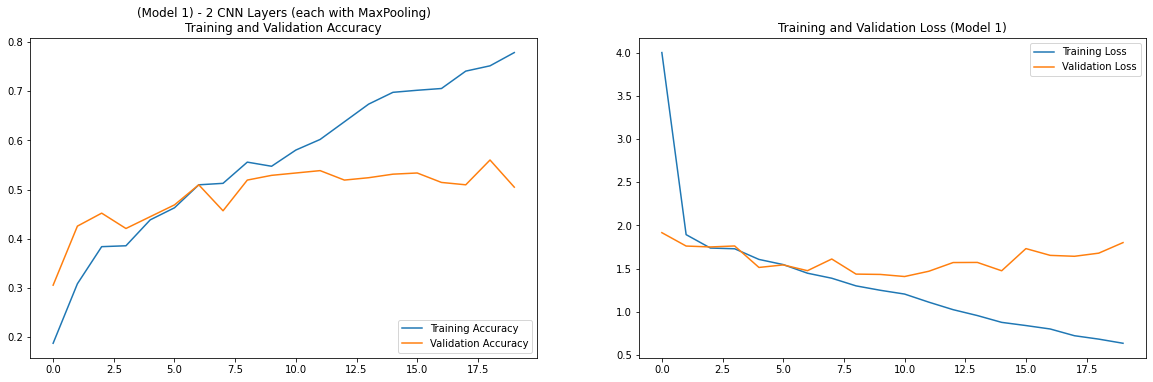

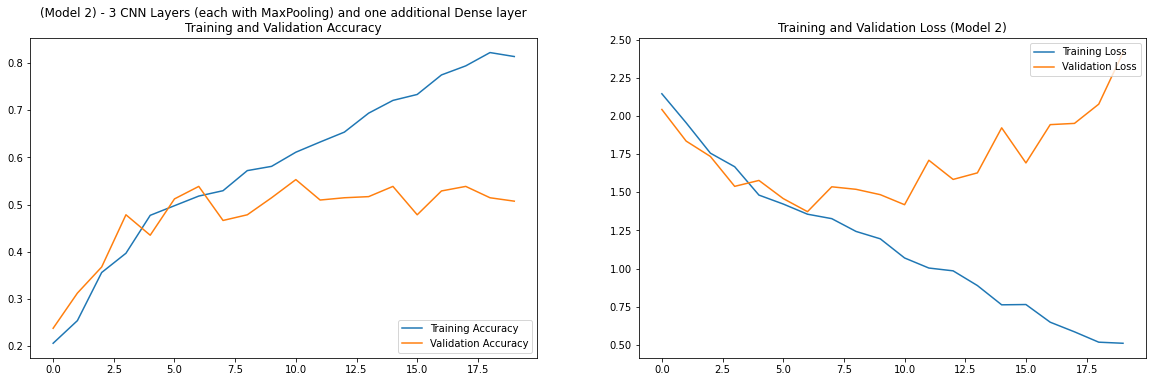

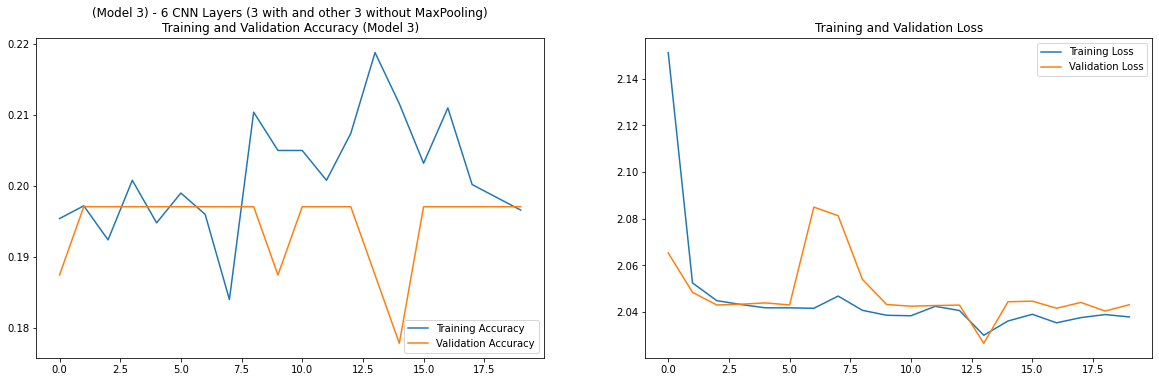

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Model 1) - 2 CNN Layers (each with MaxPooling)\nTraining and Validation Accuracy')

plt.subplot(3, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 1)')

###################

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 3)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Model 2) - 3 CNN Layers (each with MaxPooling) and one additional Dense layer\nTraining and Validation Accuracy')

plt.subplot(3, 2, 4)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 2)')

#################

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 5)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Model 3) - 6 CNN Layers (3 with and other 3 without MaxPooling)\nTraining and Validation Accuracy (Model 3)')

plt.subplot(3, 2, 6)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Again from above graphs it is clear that, first two models indicate the overfitting and third model is underfitting. Let us address these issues in the below model building exercise.

4 Improving Model Performance

4.1 Adding high dropout value

In [ ]:
tf.keras.backend.clear_session()
model3=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])


model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')


epochs = 20
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 96ms/step - loss: 2.1692 - accuracy: 0.1780 - val_loss: 2.0756 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0395 - accuracy: 0.1797 - val_loss: 2.0330 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0280 - accuracy: 0.1908 - val_loss: 2.0271 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0266 - accuracy: 0.1987 - val_loss: 2.0266 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 5s 94ms/step - loss: 2.0357 - accuracy: 0.1769 - val_loss: 2.0360 - val_accuracy: 0.1924
Epoch 6/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0377 - accuracy: 0.1897 - val_loss: 2.0314 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 5s 94ms/step - loss: 2.0262 - accuracy: 0.1914 - val_loss: 2.0220 - val_accuracy: 0.2058
Epoch 8/20
56

4.2 Lowering dropout value a bit but keeping it higher than basic models

In [ ]:
tf.keras.backend.clear_session()
model4=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

epochs = 20
history4 = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 95ms/step - loss: 2.1347 - accuracy: 0.1936 - val_loss: 2.0152 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 1.9747 - accuracy: 0.2612 - val_loss: 1.8353 - val_accuracy: 0.3244
Epoch 3/20
56/56 [==============================] - 5s 93ms/step - loss: 1.7920 - accuracy: 0.3510 - val_loss: 1.7016 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 1.7348 - accuracy: 0.3544 - val_loss: 1.5977 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 5s 94ms/step - loss: 1.6835 - accuracy: 0.3817 - val_loss: 1.5827 - val_accuracy: 0.4318
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 1.6228 - accuracy: 0.4085 - val_loss: 1.5765 - val_accuracy: 0.4474
Epoch 7/20
56/56 [==============================] - 5s 95ms/step - loss: 1.6232 - accuracy: 0.4185 - val_loss: 1.5641 - val_accuracy: 0.4631
Epoch 8/20
56

4.3 Adding some more layers to above model, just to check if performance changes or not

In [ ]:
tf.keras.backend.clear_session()
model5=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

epochs = 20
history5 = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 97ms/step - loss: 2.0571 - accuracy: 0.1981 - val_loss: 2.0421 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 94ms/step - loss: 1.9933 - accuracy: 0.2081 - val_loss: 1.9362 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 1.9383 - accuracy: 0.2606 - val_loss: 1.8510 - val_accuracy: 0.3110
Epoch 4/20
56/56 [==============================] - 5s 96ms/step - loss: 1.8656 - accuracy: 0.3131 - val_loss: 1.7498 - val_accuracy: 0.3535
Epoch 5/20
56/56 [==============================] - 5s 96ms/step - loss: 1.7447 - accuracy: 0.3438 - val_loss: 1.7528 - val_accuracy: 0.3289
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 1.7172 - accuracy: 0.3672 - val_loss: 1.6667 - val_accuracy: 0.3848
Epoch 7/20
56/56 [==============================] - 5s 98ms/step - loss: 1.6549 - accuracy: 0.3923 - val_loss: 1.6237 - val_accuracy: 0.4497
Epoch 8/20
56

4.4 Visualizing Dropout Increae Effect in our model building exercise

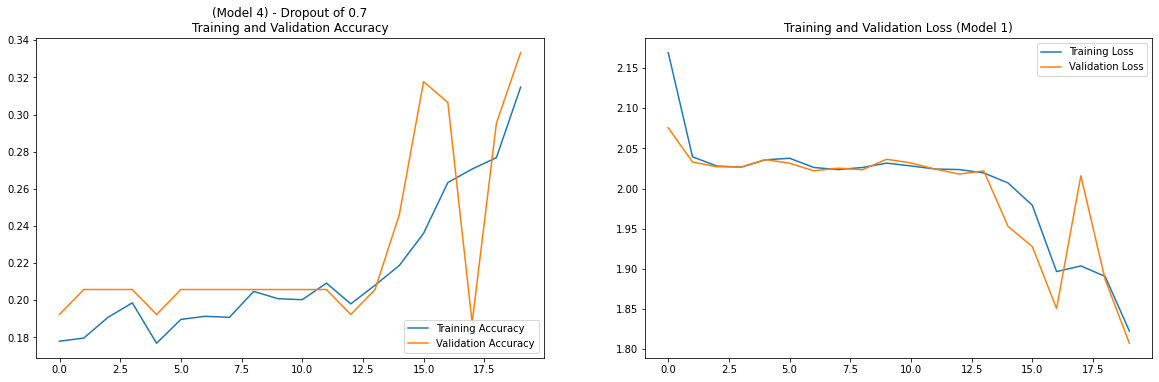

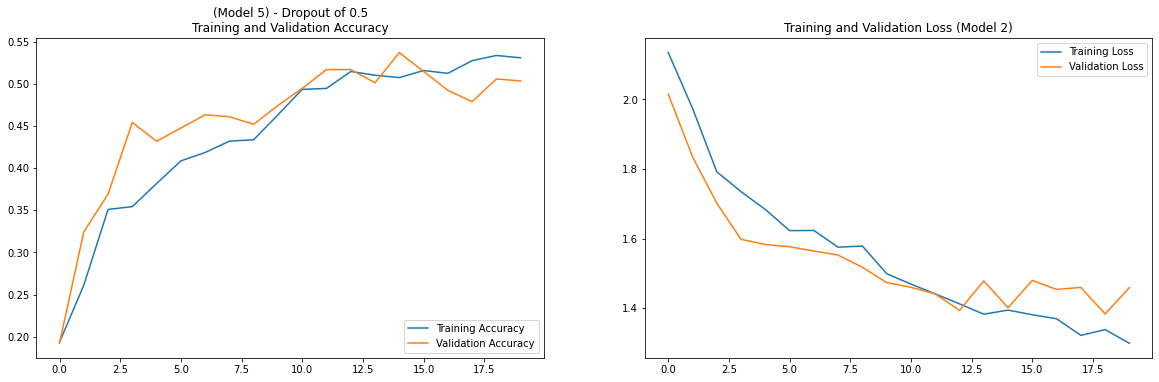

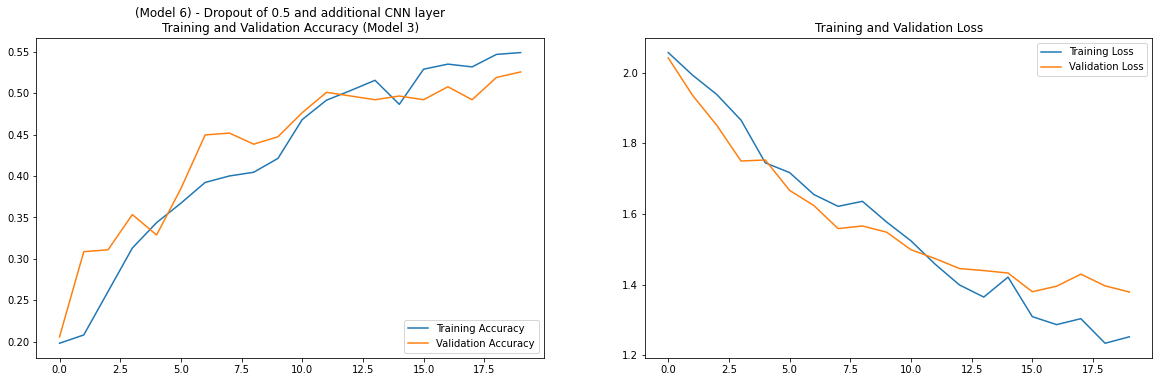

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Model 4) - Dropout of 0.7\nTraining and Validation Accuracy')

plt.subplot(3, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 1)')

###################

acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 3)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Model 5) - Dropout of 0.5\nTraining and Validation Accuracy')

plt.subplot(3, 2, 4)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 2)')

#################

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 5)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Model 6) - Dropout of 0.5 and additional CNN layer\nTraining and Validation Accuracy (Model 3)')

plt.subplot(3, 2, 6)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

It is clear from above graphs that, overfitting issue is handled very well after increase in dropout value. Accuracy is quite low but this can be sorted by applying some more techniques to these models.

Second model in above shows better accuracy amongst these three.

Now let us implement augmenation to check if that improves the accuracy further including no-overfitting

5. Data Augmentation

5.1 Implementing data augmentation using Keras library with basic parameters

In [ ]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

5.2 Visualizing images after implementing data augmentation

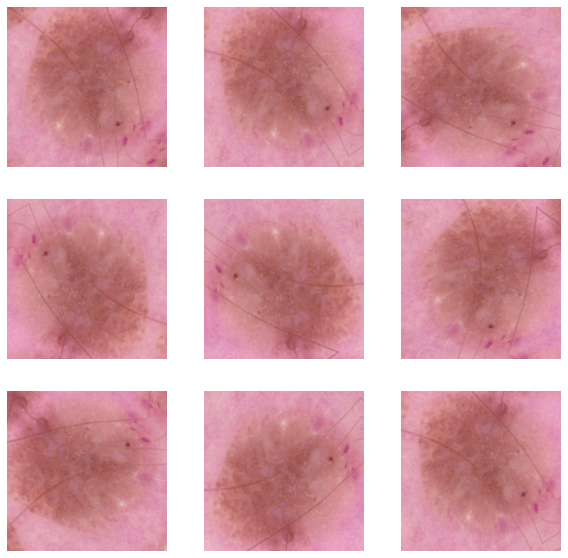

In [ ]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

5.3.1 First model using data augmentation layers

In [ ]:
tf.keras.backend.clear_session()
model6_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])


model6_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')


epochs = 20
history6 = model6_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 97ms/step - loss: 2.5095 - accuracy: 0.2020 - val_loss: 2.1698 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 95ms/step - loss: 2.1534 - accuracy: 0.2065 - val_loss: 2.1409 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 95ms/step - loss: 2.1245 - accuracy: 0.2059 - val_loss: 2.1140 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 95ms/step - loss: 2.0981 - accuracy: 0.2065 - val_loss: 2.0898 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 5s 96ms/step - loss: 2.0758 - accuracy: 0.2054 - val_loss: 2.0700 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 2.0556 - accuracy: 0.2042 - val_loss: 2.0533 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 5s 96ms/step - loss: 2.0409 - accuracy: 0.2065 - val_loss: 2.0419 - val_accuracy: 0.2058
Epoch 8/20
56

5.3.2 Second model using data augmentation layers

In [ ]:
tf.keras.backend.clear_session()
model7_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

model7_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

epochs = 20
history7 = model7_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 99ms/step - loss: 2.0955 - accuracy: 0.1758 - val_loss: 2.0363 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 97ms/step - loss: 2.0336 - accuracy: 0.1897 - val_loss: 2.0398 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 96ms/step - loss: 2.0336 - accuracy: 0.2015 - val_loss: 2.0283 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 97ms/step - loss: 2.0288 - accuracy: 0.1942 - val_loss: 2.0264 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 6s 98ms/step - loss: 2.0244 - accuracy: 0.2065 - val_loss: 2.0208 - val_accuracy: 0.1924
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 2.0117 - accuracy: 0.2020 - val_loss: 2.0351 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 5s 97ms/step - loss: 2.0309 - accuracy: 0.1975 - val_loss: 2.0300 - val_accuracy: 0.2058
Epoch 8/20
56

5.3.3 Third model using data augmentation layers

In [ ]:
tf.keras.backend.clear_session()
model8_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

model8_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

epochs = 20
history8 = model8_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 102ms/step - loss: 2.0748 - accuracy: 0.1892 - val_loss: 2.0653 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 6s 99ms/step - loss: 2.0337 - accuracy: 0.2059 - val_loss: 2.0400 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 98ms/step - loss: 2.0384 - accuracy: 0.1802 - val_loss: 2.0286 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 6s 99ms/step - loss: 2.0206 - accuracy: 0.2048 - val_loss: 2.0279 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 6s 99ms/step - loss: 2.0312 - accuracy: 0.2042 - val_loss: 2.0254 - val_accuracy: 0.1924
Epoch 6/20
56/56 [==============================] - 6s 99ms/step - loss: 2.0236 - accuracy: 0.1903 - val_loss: 2.0245 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 6s 99ms/step - loss: 2.0189 - accuracy: 0.2182 - val_loss: 2.0294 - val_accuracy: 0.1924
Epoch 8/20
5

5.4 Visualizing Effect of Data Augmentation on our Model Building Exercise

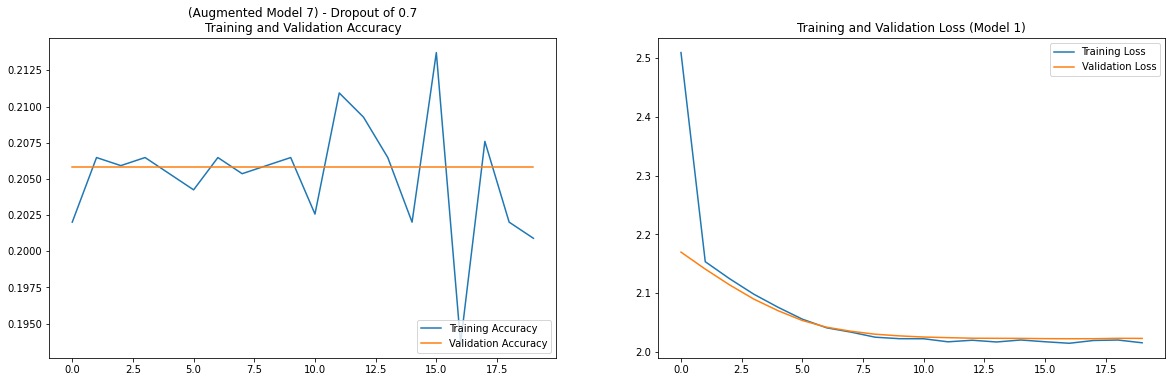

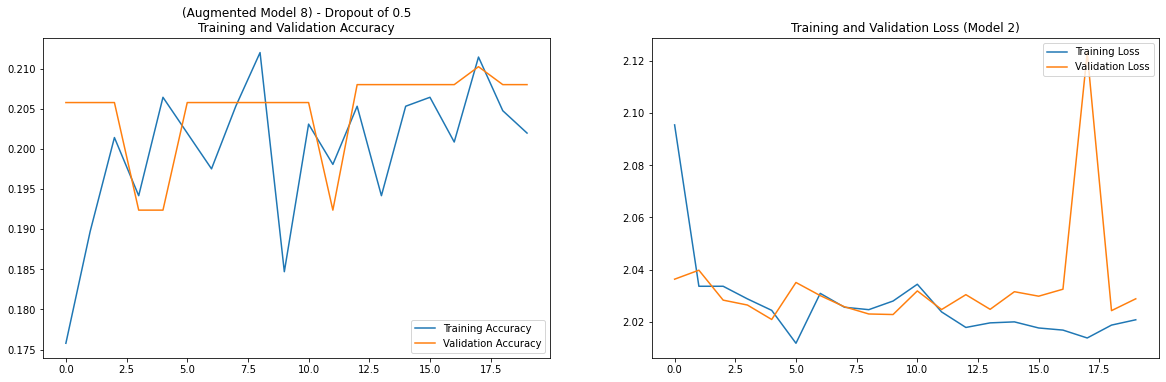

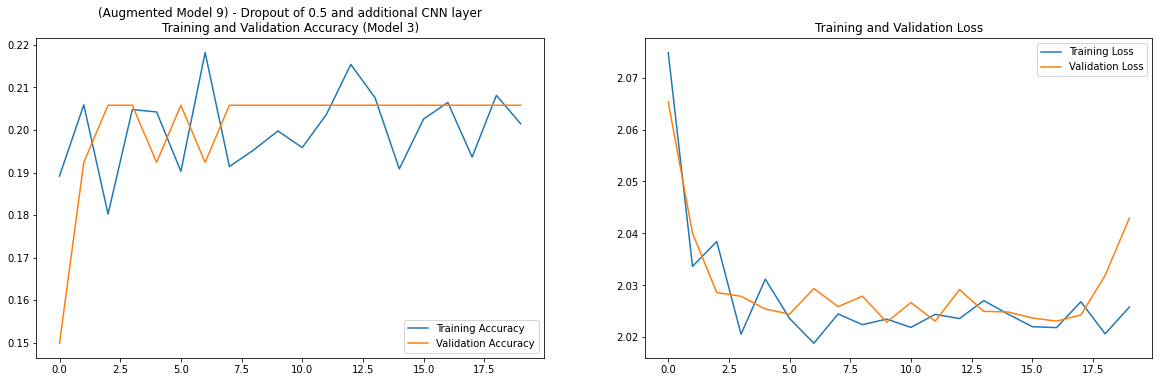

In [ ]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Augmented Model 7) - Dropout of 0.7\nTraining and Validation Accuracy')

plt.subplot(3, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 1)')

###################

acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 3)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Augmented Model 8) - Dropout of 0.5\nTraining and Validation Accuracy')

plt.subplot(3, 2, 4)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 2)')

#################

acc = history8.history['accuracy']
val_acc = history8.history['val_accuracy']

loss = history8.history['loss']
val_loss = history8.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 5)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Augmented Model 9) - Dropout of 0.5 and additional CNN layer\nTraining and Validation Accuracy (Model 3)')

plt.subplot(3, 2, 6)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

We can clearly see that 2nd and 3rd models are not showing overfitting effect and also we can further improve our model for improving accuracy.

Let us check the data imbalance in the data and see if anything can be done in that area to improve accuracy

6 Handling Data Imbalance In The Data

6.1 Check for data imbalance

In [ ]:
for i in class_names:
    directory =train_path+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


We can easily observe that the data is not correctly distributed across all the disease types. Hence there exists data imbalance. So in order to address this issue, let us use Augmentor library to create additional images (500) to every class so that noone dominates during the analysis

6.2 Installing Augmentor library

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


6.3 Using Augmentor to create 500 images in every class using various hyperparameters of this library

In [ ]:
path_to_training_dataset=train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/SkinCancerData/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DA791EE50>: 100%|██████████| 500/500 [00:17<00:00, 28.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/SkinCancerData/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DA863D6D0>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/SkinCancerData/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DA8616450>: 100%|██████████| 500/500 [00:18<00:00, 27.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/SkinCancerData/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9DA788D350>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/SkinCancerData/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DA7882E10>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/SkinCancerData/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9DA6D24E10>: 100%|██████████| 500/500 [00:18<00:00, 27.63 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/SkinCancerData/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9ED2616A90>: 100%|██████████| 500/500 [00:40<00:00, 12.28 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/SkinCancerData/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DA7887250>: 100%|██████████| 500/500 [00:18<00:00, 27.62 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/SkinCancerData/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DA86A5B10>: 100%|██████████| 500/500 [00:17<00:00, 28.42 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Check the new number of images in every class

In [ ]:
for i in class_names:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Create new training and validation data using newly created images

In [ ]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


6.4 Model building on balanced dataset

6.4.1 Building basic model again just with balanced dataset this time

In [ ]:
tf.keras.backend.clear_session()
model_balanced1=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

model_balanced1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

epochs = 30
## Your code goes here, use 50 epochs.
history9 = model_balanced1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 188ms/step - loss: 2.2891 - accuracy: 0.2494 - val_loss: 1.6722 - val_accuracy: 0.3987
Epoch 2/30
169/169 [==============================] - 31s 180ms/step - loss: 1.5033 - accuracy: 0.4203 - val_loss: 1.3875 - val_accuracy: 0.4729
Epoch 3/30
169/169 [==============================] - 32s 181ms/step - loss: 1.3471 - accuracy: 0.4935 - val_loss: 1.2825 - val_accuracy: 0.5271
Epoch 4/30
169/169 [==============================] - 31s 180ms/step - loss: 1.1941 - accuracy: 0.5549 - val_loss: 1.1207 - val_accuracy: 0.5924
Epoch 5/30
169/169 [==============================] - 31s 179ms/step - loss: 1.0731 - accuracy: 0.6066 - val_loss: 1.3340 - val_accuracy: 0.5457
Epoch 6/30
169/169 [==============================] - 32s 181ms/step - loss: 0.9391 - accuracy: 0.6511 - val_loss: 0.9458 - val_accuracy: 0.6511
Epoch 7/30
169/169 [==============================] - 31s 180ms/step - loss: 0.8030 - accuracy: 0.7077 - val_loss: 0.9184 - val_ac

6.4.2 Model building on Best Model that we got from after adding dropout of 0.5 to basic model

In [ ]:
tf.keras.backend.clear_session()
model_balanced2=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

model_balanced2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

epochs = 30
history10 = model_balanced2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 35s 196ms/step - loss: 2.1850 - accuracy: 0.1348 - val_loss: 2.1946 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 34s 196ms/step - loss: 2.1795 - accuracy: 0.1367 - val_loss: 2.1882 - val_accuracy: 0.1403
Epoch 3/30
169/169 [==============================] - 34s 195ms/step - loss: 2.1788 - accuracy: 0.1343 - val_loss: 2.1895 - val_accuracy: 0.1403
Epoch 4/30
169/169 [==============================] - 34s 195ms/step - loss: 2.1792 - accuracy: 0.1400 - val_loss: 2.1887 - val_accuracy: 0.1403
Epoch 5/30
169/169 [==============================] - 35s 200ms/step - loss: 2.1784 - accuracy: 0.1435 - val_loss: 2.1887 - val_accuracy: 0.1403
Epoch 6/30
169/169 [==============================] - 34s 197ms/step - loss: 2.1787 - accuracy: 0.1409 - val_loss: 2.1869 - val_accuracy: 0.1403
Epoch 7/30
169/169 [==============================] - 34s 196ms/step - loss: 2.1776 - accuracy: 0.1382 - val_loss: 2.1874 - val_ac

6.4.3 Model building with Balanced Data and earlier tried Augmented model

In [ ]:
tf.keras.backend.clear_session()
model_balanced4=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

model_balanced4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

epochs = 30
history12 = model_balanced4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 36s 198ms/step - loss: 2.1860 - accuracy: 0.1554 - val_loss: 2.1242 - val_accuracy: 0.1997
Epoch 2/30
169/169 [==============================] - 34s 197ms/step - loss: 1.9699 - accuracy: 0.2400 - val_loss: 1.8639 - val_accuracy: 0.3051
Epoch 3/30
169/169 [==============================] - 34s 195ms/step - loss: 1.7077 - accuracy: 0.3453 - val_loss: 1.6134 - val_accuracy: 0.3883
Epoch 4/30
169/169 [==============================] - 34s 197ms/step - loss: 1.6140 - accuracy: 0.3785 - val_loss: 1.4876 - val_accuracy: 0.4187
Epoch 5/30
169/169 [==============================] - 34s 197ms/step - loss: 1.5452 - accuracy: 0.3961 - val_loss: 1.5870 - val_accuracy: 0.4039
Epoch 6/30
169/169 [==============================] - 34s 196ms/step - loss: 1.5555 - accuracy: 0.3978 - val_loss: 1.4488 - val_accuracy: 0.4328
Epoch 7/30
169/169 [==============================] - 34s 196ms/step - loss: 1.4833 - accuracy: 0.4184 - val_loss: 1.4446 - val_ac

6.5 Visualizing model performance of model that are created with balanced dataset

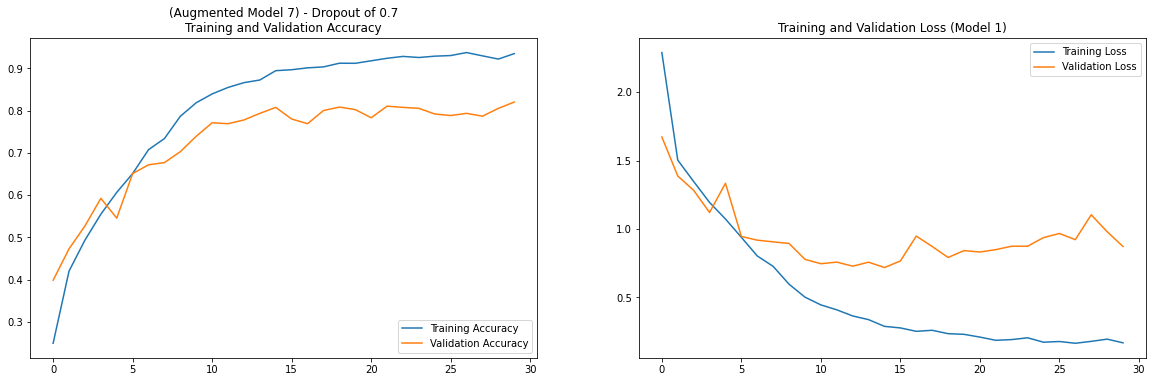

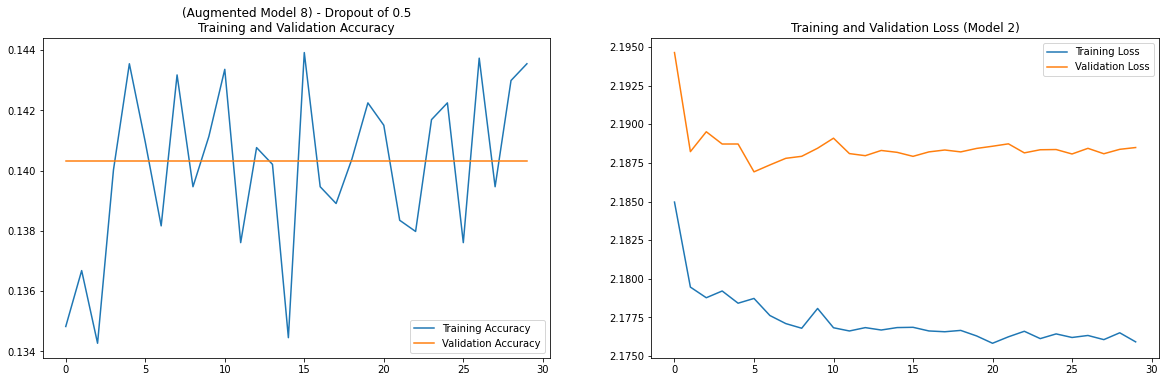

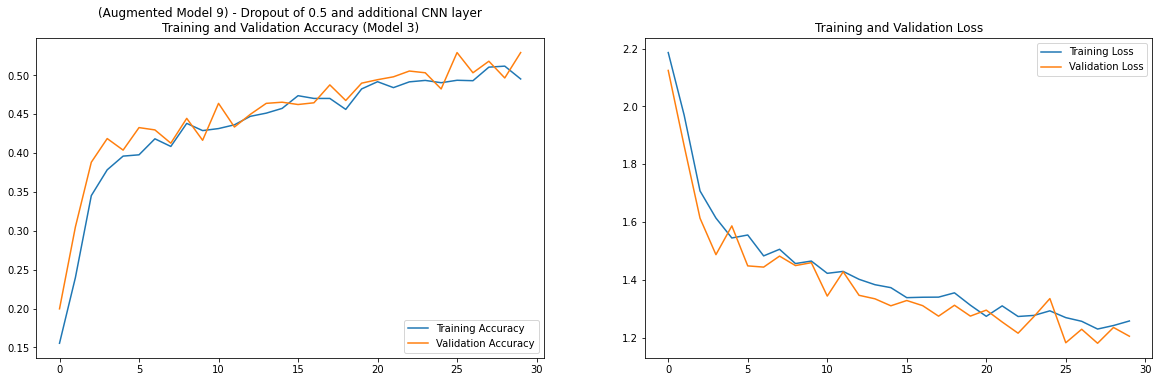

In [ ]:
acc = history9.history['accuracy']
val_acc = history9.history['val_accuracy']

loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Augmented Model 7) - Dropout of 0.7\nTraining and Validation Accuracy')

plt.subplot(3, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 1)')

###################

acc = history10.history['accuracy']
val_acc = history10.history['val_accuracy']

loss = history10.history['loss']
val_loss = history10.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 3)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Augmented Model 8) - Dropout of 0.5\nTraining and Validation Accuracy')

plt.subplot(3, 2, 4)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 2)')

#################

acc = history12.history['accuracy']
val_acc = history12.history['val_accuracy']

loss = history12.history['loss']
val_loss = history12.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 5)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('(Augmented Model 9) - Dropout of 0.5 and additional CNN layer\nTraining and Validation Accuracy (Model 3)')

plt.subplot(3, 2, 6)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

We can clearly see that, the basic model with balanced data does very good in terms of accuracy of both train and validation. Hence this turns out to be the best model out of this exercise.

Third model also does well as there is not overfitting. The accuracy needs to be further improved for this model and number of epochs may have effect here. We can check if increasing number of epochs to something like 75 or 100 does any good with this model.